In [2]:
from pathlib import Path
from typing import Tuple
from collections import defaultdict

import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns

# TODO

- [ ] Attention au temps de suivi: si qqn a pas d'événement, c'est pê que le temps de suivi est pas assez long. Il vaudrait mieux les supprimer. Censurer les patiens qui viennent d'arriver

P2:
- [ ] Appliquer le reduction sur les 3 
- [ ] essayer de faire la diff de chrom entre les 3 
- [ ] essayer d'overfitter pour voir si le modèle peut apprendre
- [ ] nouvelle variable histologique : bon ou mauvais répondeur
- [ ] eux font le NMF. Ici les données sont + sparse car dans le sang, et pas sur la tumeur.

# Load processed data

In [3]:
OUTPUT_DIR = Path('..') / 'data' / 'intermediate'

# merged
data_all = pd.read_csv(OUTPUT_DIR / 'data_metadata.csv')    # all time points

In [4]:
data_all.head()

,sex,age,pub,htum,meta_bis,chimgr,rep_histo,relapse,etat2,time_OS,...,2:225000001-226000000_ratio_FIN_TT,2:225000001-226000000_zscore_AVANT_CHIR,2:225000001-226000000_zscore_DIAG,2:225000001-226000000_zscore_FIN_TT,8:76000001-77000000_ratio_AVANT_CHIR,8:76000001-77000000_ratio_DIAG,8:76000001-77000000_ratio_FIN_TT,8:76000001-77000000_zscore_AVANT_CHIR,8:76000001-77000000_zscore_DIAG,8:76000001-77000000_zscore_FIN_TT
0,Feminin,20.55,0.0,11.6,1,MTX,GR,0,0,2628.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Feminin,12.91,1.0,9.3,0,MTX,GR,1,0,1786.0,...,NaN,NaN,-1.706492,NaN,0.149701,0.245046,NaN,3.923849,1.834662,NaN
2,Masculin,4.71,1.0,10.2,0,MTX,NaN,1,1,261.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Feminin,15.62,0.0,15.0,1,MTX,NaN,1,0,1100.0,...,-0.009755,NaN,NaN,-0.29966,NaN,NaN,-0.031106,NaN,NaN,-0.774995
4,Feminin,12.56,0.0,11.4,1,MTX,NaN,1,1,258.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# removing observations with not enought time

/opt/homebrew/Caskroom/miniconda/base/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='time_OS', ylabel='Density'>

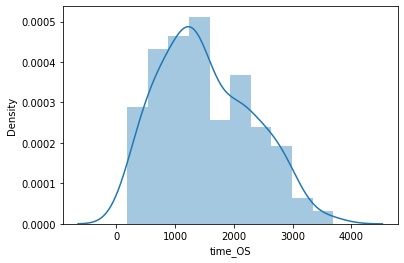

In [9]:
sns.distplot(data_all.time_OS, bins=10)

In [ ]:
sns.distplot(data_all.time_OS, bins=10)

## remove patients with low observation time

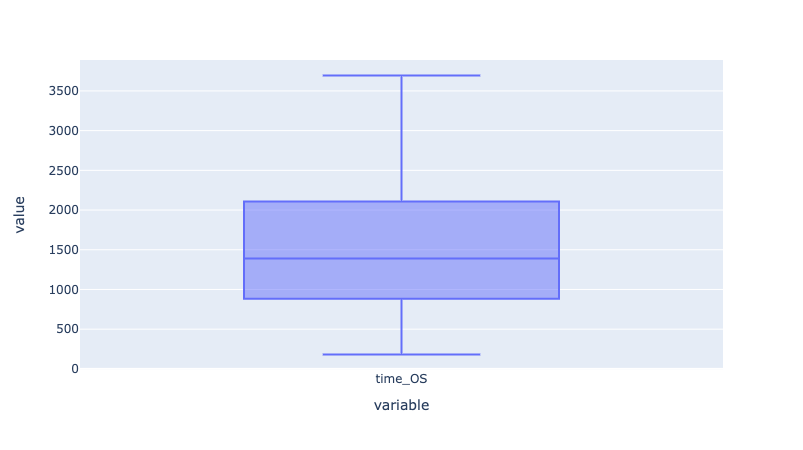

In [33]:
# Survie globale jusqu’à la dernière date de suivi
px.box(data_all.time_OS)

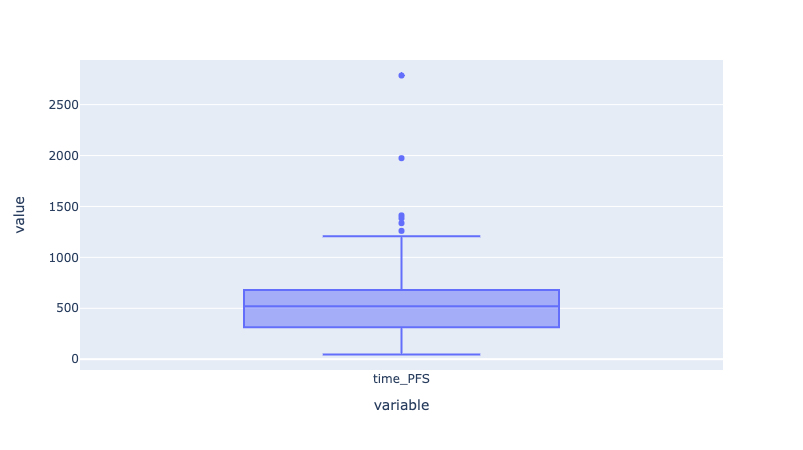

In [34]:
# Temps jusqu’à la rechute (jours)
px.box(data_all.time_PFS)

In [56]:
MIN_OS_TIME = 300
MIN_PFS_TIME = 100

data_subset = data_all[(data_all.time_OS > N_DAYS_MIN)
    & (
        (data_all.time_PFS > MIN_PFS_TIME) | (data_all.time_PFS.isna())    # is null or > threshold
    )].copy()
print(f"keeping {len(data_subset)}/{len(data_all)} ({len(data_subset)/len(data_all)})")

keeping 168/182 (0.9230769230769231)


# Data Analysis

In [57]:
data_all.relapse = data_all.relapse.astype("category")

In [58]:
import plotly.express as px
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)

<AxesSubplot:ylabel='relapse'>

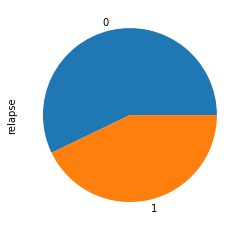

In [59]:
# dataset is balanced, we can use AUC as metric
data_all.relapse.value_counts().plot(kind='pie')

<AxesSubplot:ylabel='relapse'>

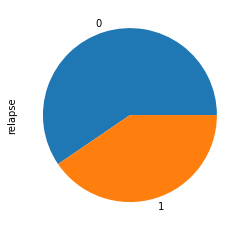

In [61]:
# dataset is balanced, we can use AUC as metric
data_subset.relapse.value_counts().plot(kind='pie')

## Outliers

In [62]:
outliers_ids = ['OS2006_34', 'OS2006_548', 'OS2006_20']

# ML models on metadata

## Compute features

In [83]:
features = data_subset.copy()
print(f'Initial features shape : {features.shape}')

features['sex'] = features.apply(lambda x: 0 if x['sex'] == 'Feminin' else 1, axis=1)
features = features[~features['patient_id'].isin(outliers_ids)]
features.reset_index(drop=True, inplace=True)

print(f'Features shape after some cleaning: {features.shape}')

label = 'relapse'
labels = features[label]

data = features.copy()   # dataset with target for pycaret

Initial features shape : (168, 15004)
Features shape after some cleaning: (165, 15004)


In [84]:
data.chimgr.value_counts(dropna=False)

MTX       140
API-AI     20
NaN         5
Name: chimgr, dtype: int64

In [98]:
data.rep_histo.value_counts(dropna=False)

1.0    94
0.0    68
NaN     3
Name: rep_histo, dtype: int64

In [85]:
REP_HISTO_MAPPER = {
    'GR': 1,   # good histemiological response
    'PR': 0,   # bad histemiological response
}
data['rep_histo'] = data.rep_histo.map(REP_HISTO_MAPPER)

In [87]:
CAT_FEATURES = ['sex', 'pub', 'meta_bis', 'chimgr', "rep_histo"]
NUM_FEATURES = ['age', 'htum', 'cpa_diagnostic', 'cpa_chirurgie', 'cpa_finTT']

data = data[CAT_FEATURES + NUM_FEATURES + [label]]

## First baseline with Pycaret

In [88]:
from pycaret.classification import *
from sklearn import __version__

print(__version__)

0.23.2


In [89]:
clf1 = setup(
    data,
    target=label,
    categorical_features=CAT_FEATURES,
    numeric_features=NUM_FEATURES,
    normalize=True,
    normalize_method='zscore',
    feature_selection=False,
)

,Description,Value
0,session_id,590
1,Target,relapse
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(165, 11)"
5,Missing Values,True
6,Numeric Features,5
7,Categorical Features,5
8,Ordinal Features,False
9,High Cardinality Features,False


In [90]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7000,0.7367,0.6250,0.6681,0.6218,0.3772,0.3964,0.3690
ridge,Ridge Classifier,0.6659,0.0000,0.5650,0.6400,0.5845,0.3094,0.3211,0.0070
lda,Linear Discriminant Analysis,0.6659,0.6976,0.5450,0.6433,0.5772,0.3070,0.3177,0.0040
rf,Random Forest Classifier,0.6417,0.6636,0.4850,0.6183,0.5317,0.2477,0.2615,0.0410
lightgbm,Light Gradient Boosting Machine,0.6265,0.6819,0.4850,0.5633,0.5149,0.2139,0.2174,0.1180
svm,SVM - Linear Kernel,0.6068,0.0000,0.4850,0.6552,0.4979,0.1870,0.2310,0.0290
et,Extra Trees Classifier,0.6068,0.6336,0.5050,0.5879,0.5152,0.1918,0.2072,0.0390
xgboost,Extreme Gradient Boosting,0.5811,0.6314,0.4650,0.5179,0.4841,0.1337,0.1367,0.1590
dt,Decision Tree Classifier,0.5795,0.5756,0.5250,0.5000,0.4955,0.1543,0.1522,0.0030
qda,Quadratic Discriminant Analysis,0.5735,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0090


In [91]:
# we create the model that maximize AUC
model = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9167,0.9714,1.0000,0.8333,0.9091,0.8333,0.8452
1,0.8333,0.7714,1.0000,0.7143,0.8333,0.6757,0.7143
2,0.5833,0.6000,0.6000,0.5000,0.5455,0.1667,0.1690
3,0.8333,0.8857,0.6000,1.0000,0.7500,0.6364,0.6831
4,0.8333,0.9429,0.8000,0.8000,0.8000,0.6571,0.6571
5,0.7273,0.8000,0.8000,0.6667,0.7273,0.4590,0.4667
6,0.4545,0.5667,0.2000,0.3333,0.2500,-0.1379,-0.1491
7,0.5455,0.6000,0.6000,0.5000,0.5455,0.0984,0.1000
8,0.7273,0.8000,0.4000,1.0000,0.5714,0.4211,0.5164
9,0.5455,0.4286,0.2500,0.3333,0.2857,-0.0377,-0.0386


In [92]:
tuned_model = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9167,0.9714,1.0000,0.8333,0.9091,0.8333,0.8452
1,0.8333,0.7714,1.0000,0.7143,0.8333,0.6757,0.7143
2,0.5833,0.6000,0.6000,0.5000,0.5455,0.1667,0.1690
3,0.9167,0.8857,0.8000,1.0000,0.8889,0.8235,0.8367
4,0.8333,0.9429,0.8000,0.8000,0.8000,0.6571,0.6571
5,0.7273,0.8000,0.8000,0.6667,0.7273,0.4590,0.4667
6,0.5455,0.5667,0.4000,0.5000,0.4444,0.0678,0.0690
7,0.6364,0.6000,0.8000,0.5714,0.6667,0.2903,0.3105
8,0.6364,0.7667,0.4000,0.6667,0.5000,0.2414,0.2609
9,0.5455,0.4286,0.2500,0.3333,0.2857,-0.0377,-0.0386


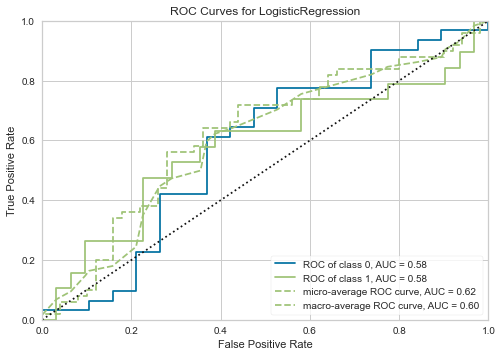

In [93]:
plot_model(tuned_model)

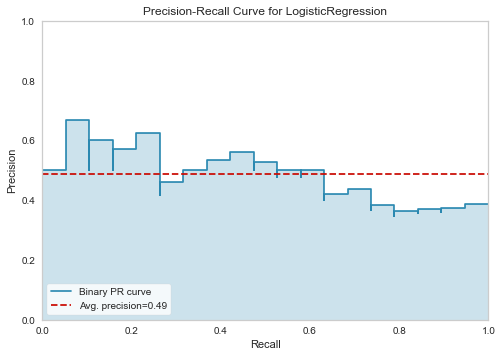

In [94]:
plot_model(tuned_model, plot = 'pr')

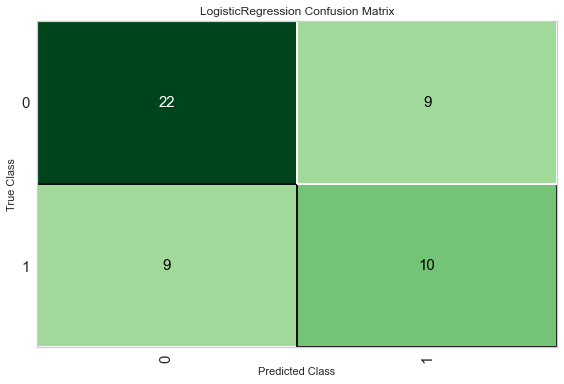

In [95]:
plot_model(tuned_model, plot = 'confusion_matrix')

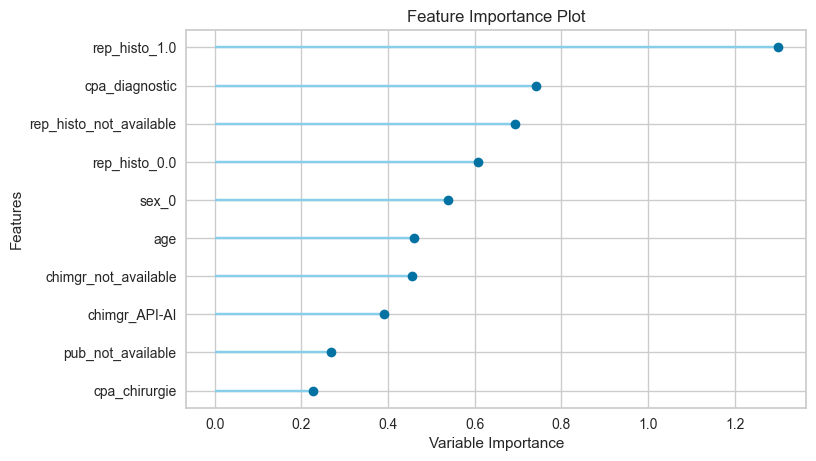

In [96]:
plot_model(tuned_model, plot = 'feature')

In [97]:
interpret_model(tuned_model)

TypeError: This function only supports tree based models for binary classification: lightgbm, et, xgboost, dt, rf.

# Processing gene data

## removing gene cols with missing values

In [103]:
ratio_cols = [col for col in data_all.columns.tolist() if "ratio" in col]
zscore_cols = [col for col in data_all.columns.tolist() if "zscore" in col]
gene_ratio = data_all[ratio_cols]
gene_zscore = data_all[zscore_cols]

In [106]:
def compute_null_ratio(df: pd.DataFrame) -> pd.DataFrame:
    return pd.DataFrame(df.isna().sum()/len(df), columns=['null_ratio']).reset_index()

In [107]:
ratio_stats = compute_null_ratio(gene_ratio)
zscore_stats = compute_null_ratio(gene_zscore)

In [108]:
def plot_distribution(df: pd.DataFrame, threshold: float = 0.0) -> None:
    sub_df = df.query(f'null_ratio > {threshold}')
    sns.distplot(sub_df['null_ratio'])

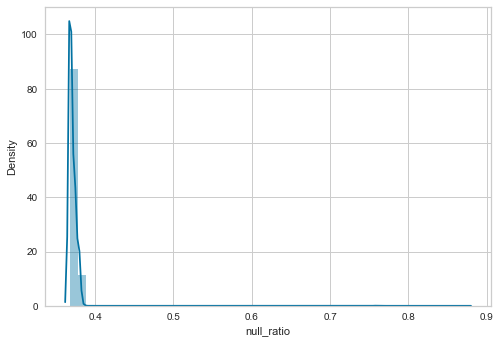

In [109]:
plot_distribution(ratio_stats)

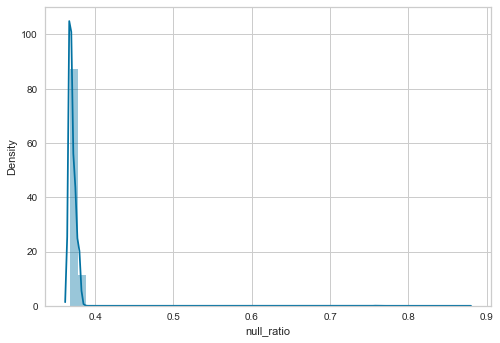

In [110]:
plot_distribution(zscore_stats)

In [111]:
both_stats = pd.concat(
    [
        ratio_stats,
        zscore_stats.rename(columns={'null_ratio': 'null_ratio_zscore', 'index': 'index_zscore'})
    ], axis=1)
both_stats.query("null_ratio != null_ratio_zscore")

,index,null_ratio,index_zscore,null_ratio_zscore
18,1:8000001-9000000_ratio_AVANT_CHIR,0.384615,1:8000001-9000000_zscore_AVANT_CHIR,0.379121
23,1:9000001-10000000_ratio_FIN_TT,0.368132,1:9000001-10000000_zscore_FIN_TT,0.373626
38,1:14000001-15000000_ratio_FIN_TT,0.368132,1:14000001-15000000_zscore_FIN_TT,0.373626
56,1:21000001-22000000_ratio_FIN_TT,0.373626,1:21000001-22000000_zscore_FIN_TT,0.368132
61,1:23000001-24000000_ratio_DIAG,0.373626,1:23000001-24000000_zscore_DIAG,0.368132
...,...,...,...,...
7345,21:35000001-36000000_ratio_DIAG,0.368132,21:35000001-36000000_zscore_DIAG,0.373626
7423,22:30000001-31000000_ratio_DIAG,0.373626,22:30000001-31000000_zscore_DIAG,0.368132
7428,22:32000001-33000000_ratio_AVANT_CHIR,0.379121,22:32000001-33000000_zscore_AVANT_CHIR,0.384615
7443,22:37000001-38000000_ratio_AVANT_CHIR,0.379121,22:37000001-38000000_zscore_AVANT_CHIR,0.373626


In [113]:
# we remove the columns with high null rates 
to_remove = both_stats.query('null_ratio > 0.2')
cols_to_remove = to_remove['index'].to_list() + to_remove['index_zscore'].to_list()
data_diag_clean = data_all.drop(columns=cols_to_remove, errors='ignore')

ratio_cols = [col for col in data_diag_clean.columns.tolist() if "ratio" in col]
zscore_cols = [col for col in data_diag_clean.columns.tolist() if "zscore" in col]

In [114]:
for col in ratio_cols + zscore_cols:
    data_diag_clean[col] = data_diag_clean[col].fillna(0.0)

## Dimensionality reduction using UMAP

### First, visualization in 3D

In [115]:
def vector_numpy_to_pandas(umap_res: np.ndarray) -> pd.DataFrame:
    df = pd.DataFrame(umap_res)
    df = df.add_prefix('dim_')
    return df

In [117]:
import umap

N_DIMS = 3

fit = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=N_DIMS,
    metric='cosine',
    random_state=42
)

u = fit.fit_transform(data_diag_clean[zscore_cols].to_numpy())

features = data_diag_clean.iloc[:,:11]
vector = vector_numpy_to_pandas(u)
features = pd.concat([features, vector], axis=1)

features.head()

ValueError: Found array with 0 feature(s) (shape=(182, 0)) while a minimum of 1 is required.

In [ ]:
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=True)
import plotly.graph_objs as go
import plotly.offline as py
import plotly.graph_objs as go
from IPython.display import Image,display

def plot_cluster(df, name=''):
    trace1 = go.Scatter3d(
        x=df['dim_0'],
        y=df['dim_1'],
        z=df['dim_2'],

        mode='markers',
        marker=dict(
            size=2,
            color=df["relapse"],
            colorscale='Viridis',   # choose a colorscale
            opacity=1
        ),
        text=df['relapse']
    )

    data = [trace1]
    layout = go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        )
    )
    fig = go.Figure(data=data, layout=layout)
    file='../reports/'+name+'.html'
    py.iplot(fig, filename=file)
    py.plot(fig, filename=file,auto_open=False)

In [ ]:
# commented to save space when versionned 
#plot_cluster(features, 'umap')

### Compute vector of N dimensions

In [110]:
len(zscore_cols)

2645

In [121]:
import umap

N_DIMS = 10

fit = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=N_DIMS,
    metric='cosine',
    random_state=42
)

u = fit.fit_transform(data_diag_clean[zscore_cols].to_numpy())

features = data_all.iloc[:,:11]
vector = vector_numpy_to_pandas(u)
features = pd.concat([features, vector], axis=1)

# Train a ML model using all these features

In [123]:
features = features[~features['patient_id'].isin(outliers_ids)]

In [131]:
COLS_TO_DROP = ['patient_id', 'etat2', 'time_OS', 'time_PFS']
features = features.drop(columns=COLS_TO_DROP, errors='ignore')

In [132]:
features.head()

,sex,age,htum,relapse,CPA_AVANT_CHIR,CPA_DIAG,CPA_FIN_TT,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9
0,Feminin,17.58,10.6,0.0,0.13178,0.15446,0.12948,6.819944,6.741635,6.552502,3.163334,2.380113,4.450327,7.125168,9.759988,3.327932,5.137546
1,Masculin,14.51,11.1,0.0,0.12377,0.34361,0.14044,7.009439,7.755746,4.909565,1.374685,2.436057,5.700484,8.502618,10.000359,3.280427,5.533571
2,Masculin,18.83,7.0,0.0,0.11279,0.17640,0.14109,6.880323,7.230412,4.378039,1.720146,2.839537,5.274788,8.151042,10.238515,3.643500,5.489123
3,Feminin,11.69,12.4,0.0,0.27524,0.56731,0.17286,6.784331,7.194227,5.372379,2.115988,2.722812,5.398668,7.920492,10.083903,3.973462,5.517278
4,Feminin,15.91,8.0,1.0,0.14314,0.28877,0.15033,7.550785,7.845530,5.454696,1.102061,1.423698,4.822525,8.000863,11.224867,3.088291,4.955470


In [134]:
clf1 = setup(
    features,
    target=label,
    categorical_features=['sex'],
    numeric_features=['age', 'htum', 'CPA_DIAG', 'CPA_AVANT_CHIR', 'CPA_FIN_TT'] + [col for col in features.columns if col.startswith('dim_')],
    normalize=True,
    normalize_method='zscore',
    feature_selection=False,
)

,Description,Value
0,session_id,3771
1,Target,relapse
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(175, 17)"
5,Missing Values,True
6,Numeric Features,15
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [135]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6196,0.0000,0.5083,0.6083,0.5194,0.2188,0.2402,0.0040
svm,SVM - Linear Kernel,0.6179,0.0000,0.6000,0.6133,0.5816,0.2318,0.2466,0.0090
lda,Linear Discriminant Analysis,0.6071,0.6542,0.4833,0.5917,0.4956,0.1938,0.2143,0.0050
lr,Logistic Regression,0.6054,0.6188,0.5167,0.5850,0.5276,0.2051,0.2169,0.6470
nb,Naive Bayes,0.5714,0.5562,0.4333,0.5500,0.4617,0.1300,0.1366,0.0040
dummy,Dummy Classifier,0.5357,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0100
gbc,Gradient Boosting Classifier,0.5071,0.4729,0.3333,0.4000,0.3538,-0.0076,-0.0282,0.0190
lightgbm,Light Gradient Boosting Machine,0.4911,0.4833,0.3583,0.4250,0.3629,-0.0355,-0.0349,0.1140
qda,Quadratic Discriminant Analysis,0.4857,0.4875,0.3500,0.3233,0.3233,-0.0344,-0.0434,0.0160
knn,K Neighbors Classifier,0.4804,0.4729,0.3333,0.4833,0.3714,-0.0369,-0.0370,0.0190


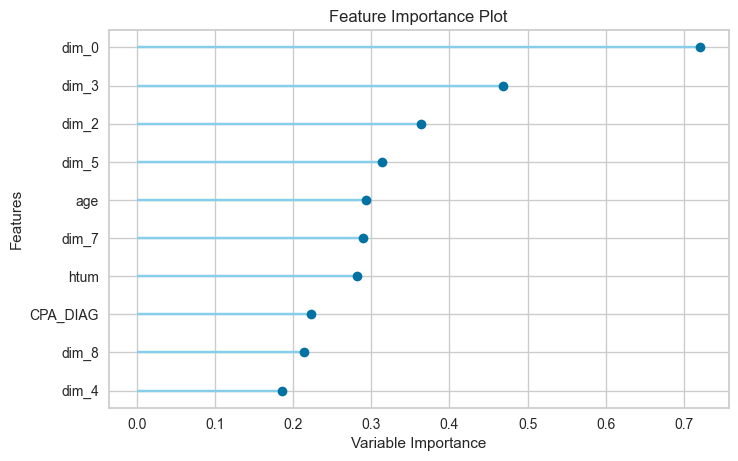

In [136]:
plot_model(best_model, plot = 'feature')

In [137]:
interpret_model(best_model)

TypeError: This function only supports tree based models for binary classification: rf, lightgbm, dt, et, xgboost.